## **Maestría en Ciencia de Datos - FDA II**
### **Daniel Martínez & Felipe Montenegro**




# **Problema a Desarrollar**

**Contexto del Negocio**

El cáncer de próstata es uno de los tipos de cáncer más comunes en hombres. La detección temprana es crucial para mejorar las tasas de supervivencia. La prueba de antígeno prostático específico (PSA) puede ayudar a detectar el cáncer de próstata en etapas tempranas, cuando es más tratable. Sin embargo, el PSA no es específico para el cáncer de próstata y puede estar elevado en otras condiciones como prostatitis o hiperplasia prostática benigna (HPB).

El antígeno prostático específico (PSA) es una proteína producida por células normales y malignas de la glándula prostática. La prueba del PSA mide el nivel de esta proteína en la sangre y es uno de los métodos más utilizados para el tamizaje del cáncer de próstata.

La EPS SaludPorTi, está interesado en priorizar la toma de está prueba, aumentando la demanda y detención temprana del Cáncer de Próstata.


**Problema de Negocio** 

La empresa ha decidido contratarlos para que construyan un modelo predictivo que permita estimar la probabilidad de que un usuario entre 48 y 60 años de edad presente resultados anormales de PSA.


**Contexto Analítico** 

Se espera que entrene diferentes familias de modelos predictivos de clasificación (SVC con diferentes kernels, Redes Neuronales poco profundas), precedidos por diferentes procesos de transformación (normalizaciones, imputación, feature engineering, dummificación, PCA, selección de features).

La evaluación de la calidad de los flujos de modelos predictivos se debe estimar utilizando la métrica de ROC_AUC.

Expliquen sus ideas, el por qué realizan las acciones, y comenten los resultados obtenidos; se espera mucho más que unos bloques de código.
La toma de decisiones sobre los datos se debe hacer considerando el contexto del problema y de los datos, no se puede ver todo solamente desde los ojos de los datos, sino también considerar el negocio.
Un Científico de Datos debe poder comunicar los puntos importantes de su trabajo en un lenguaje universal para todos los públicos.



## **1. Carga de Librerías y Lectura de Datos**

In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from IPython.display import display 
import matplotlib.ticker as mtick


import warnings
warnings.filterwarnings("ignore") 

In [2]:
df_train = pq.read_table('data/df_train.parquet').to_pandas()
df_test = pq.read_table('data/df_test.parquet').to_pandas()

## **2. Análisis Exploratorio de Datos**

Dentro de este análisis se hará un entendimiento de la estructura de los datos, en el cual es importante mencionar que se incluirán los análisis de **missing values** y **outliers**.

In [3]:
#Visualización inicial de los datos

df_train.head()

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,...,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Target,Pendiente,Intercepto,Promedio_costo
ID,,,,,,,,,,,,,,,,,,,,,
16484,12.0,3.0,3.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,58373.057143,-110021.200000,1.885690e+05
11528,6.0,1.0,1.0,2,0.5,NaN,0.0,NaN,NaN,1.0,...,0,0,0,0,0,0,0,19618.942857,-36176.133333,9.747050e+04
26630,1.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,1,398534.000000,-626628.000000,2.304723e+06
12586,6.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,1292.600000,13410.733333,5.380450e+04
11225,3.0,0.0,2.0,1,1.0,NaN,0.0,NaN,NaN,1.0,...,2,2,2,2,2,2,0,13728.714286,-27375.666667,4.134967e+04


In [4]:
#Identificamos el tipo de datos que contiene el dataset 

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23494 entries, 16484 to 9409
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MEDICAMENTOS                   23494 non-null  float64
 1   MEDICINA ESPECIALIZADA         23494 non-null  float64
 2   MEDICINA GENERAL               23494 non-null  float64
 3   Cant_gr_flia                   23494 non-null  int64  
 4   Cant_riesgos_flia_mean         23494 non-null  float64
 5   min_Tiempo_CP_Fliar            8 non-null      float64
 6   Cant_Fliar_CP                  23494 non-null  float64
 7   psa_max_gr_flia                164 non-null    float64
 8   psa_min_gr_flia                164 non-null    float64
 9   Cant_Fliar_riesgos             23494 non-null  float64
 10  cantidad_serv_flia             23494 non-null  float64
 11  Pendiente_flia                 23494 non-null  float64
 12  Intercepto_flia                23494 non-null  f

**Análizamos la proporción de datos nulos que tiene el dataset** 

Según al recomendación del negocio, se deben eliminar las variables que tengan más de 40% de datos nulos.

In [5]:
# Número total de registros
total_registros = 23494

# Contar los valores nulos por columna
nulos_por_columna = df_train.isnull().sum()

# Calcular el porcentaje de valores nulos por columna
porcentaje_nulos = (nulos_por_columna / total_registros) * 100

# Crear un DataFrame con los resultados
nulos_df = pd.DataFrame({
    'Valores Nulos': nulos_por_columna,
    '% de Nulos': porcentaje_nulos
})

# Ordenar por % de Nulos de mayor a menor
nulos_df = nulos_df.sort_values(by='% de Nulos', ascending=False)

# Mostrar el resultado
print(nulos_df)


                               Valores Nulos  % de Nulos
min_Tiempo_CP_Fliar                    23486   99.965949
psa_max_gr_flia                        23330   99.301949
psa_min_gr_flia                        23330   99.301949
PERDIDA_DE_PESO                        17723   75.436282
RIESGOS                                16283   69.307057
IMC                                    10364   44.113391
CANCER_MAMA_FAMILIAR                    6802   28.952073
AGRUPACION_DIASTOLICA                   3320   14.131268
AGRUPACION_SISTOLICA                    3320   14.131268
DIABETES_FAMILIAR                          0    0.000000
CANCER_OTRO_SITIO                          0    0.000000
CANCER_OTRO_SITIO_FAMILIAR                 0    0.000000
HIPERTENSION                               0    0.000000
HIPERTENSION_FAMILIAR                      0    0.000000
DIABETES                                   0    0.000000
MEDICAMENTOS                               0    0.000000
CORONARIOS                     

In [6]:
# Lista de columnas a eliminar
columnas_a_eliminar = [
    'min_Tiempo_CP_Fliar',
    'psa_max_gr_flia',
    'psa_min_gr_flia',
    'PERDIDA_DE_PESO',
    'RIESGOS',
    'IMC'
]

# Eliminar las columnas del dataframe
df_train2 = df_train.drop(columns=columnas_a_eliminar)

# Verificar que las columnas fueron eliminadas
print(df_train2.columns)


Index(['MEDICAMENTOS', 'MEDICINA ESPECIALIZADA', 'MEDICINA GENERAL',
       'Cant_gr_flia', 'Cant_riesgos_flia_mean', 'Cant_Fliar_CP',
       'Cant_Fliar_riesgos', 'cantidad_serv_flia', 'Pendiente_flia',
       'Intercepto_flia', 'Promedio_costo_flia', 'ESTADO_CIVI', 'PROGRAMA',
       'estrato', 'AGRUPACION_SISTOLICA', 'AGRUPACION_DIASTOLICA',
       'parentesco', 'EDAD', 'CANTIDAD_SERVICIOS', 'TIEMPO_ULTIMA_CITA',
       'conteo_dx_diferentes', 'TIEMPO_AFILIACION', 'CANCER_MAMA_FAMILIAR',
       'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 'HIPERTENSION',
       'HIPERTENSION_FAMILIAR', 'DIABETES', 'DIABETES_FAMILIAR', 'CORONARIOS',
       'CORONARIOS_FAMILIAR', 'CEREBRAL', 'CEREBRAL_FAMILIAR',
       'ENFERMEDAD_RENAL', 'ENFERMEDAD_RENAL_FAMILIAR',
       'OTROS_ANTECEDENTES_VASCULARES', 'Target', 'Pendiente', 'Intercepto',
       'Promedio_costo'],
      dtype='object')


Ahora bien, con el objetivo de evitar ruido en el modelo se procederán a eliminar algunas varibales que no estarían directamente relacionadas con el estado de salud del paciente o los factores de riesgo asociados al PSA.

In [7]:
# Lista de columnas adicionales sugeridas para eliminar
columnas_a_eliminar_adicionales = [
    'cantidad_serv_flia', 
    'Pendiente_flia', 
    'Promedio_costo_flia', 
    'Intercepto_flia', 
    'Intercepto', 
    'Pendiente'
]

# Eliminar las columnas del dataframe
df_train_3 = df_train2.drop(columns=columnas_a_eliminar_adicionales)

# Verificar que las columnas fueron eliminadas
print(df_train_3.columns)


Index(['MEDICAMENTOS', 'MEDICINA ESPECIALIZADA', 'MEDICINA GENERAL',
       'Cant_gr_flia', 'Cant_riesgos_flia_mean', 'Cant_Fliar_CP',
       'Cant_Fliar_riesgos', 'ESTADO_CIVI', 'PROGRAMA', 'estrato',
       'AGRUPACION_SISTOLICA', 'AGRUPACION_DIASTOLICA', 'parentesco', 'EDAD',
       'CANTIDAD_SERVICIOS', 'TIEMPO_ULTIMA_CITA', 'conteo_dx_diferentes',
       'TIEMPO_AFILIACION', 'CANCER_MAMA_FAMILIAR', 'CANCER_OTRO_SITIO',
       'CANCER_OTRO_SITIO_FAMILIAR', 'HIPERTENSION', 'HIPERTENSION_FAMILIAR',
       'DIABETES', 'DIABETES_FAMILIAR', 'CORONARIOS', 'CORONARIOS_FAMILIAR',
       'CEREBRAL', 'CEREBRAL_FAMILIAR', 'ENFERMEDAD_RENAL',
       'ENFERMEDAD_RENAL_FAMILIAR', 'OTROS_ANTECEDENTES_VASCULARES', 'Target',
       'Promedio_costo'],
      dtype='object')


Con los datos que quedaron, nuevamente identificamos la cantidad de valores nulos que tenemos en las variables. 

In [8]:
# Calcular el número de valores nulos por cada columna
valores_nulos = df_train_3.isnull().sum()

# Calcular el porcentaje de valores nulos en relación al total de registros
porcentaje_nulos = (valores_nulos / 23494) * 100

# Crear un dataframe con los resultados
nulos_df = pd.DataFrame({
    'Valores Nulos': valores_nulos,
    '% Nulos': porcentaje_nulos
})

# Mostrar el resultado
print(nulos_df)


                               Valores Nulos    % Nulos
MEDICAMENTOS                               0   0.000000
MEDICINA ESPECIALIZADA                     0   0.000000
MEDICINA GENERAL                           0   0.000000
Cant_gr_flia                               0   0.000000
Cant_riesgos_flia_mean                     0   0.000000
Cant_Fliar_CP                              0   0.000000
Cant_Fliar_riesgos                         0   0.000000
ESTADO_CIVI                                0   0.000000
PROGRAMA                                   0   0.000000
estrato                                    0   0.000000
AGRUPACION_SISTOLICA                    3320  14.131268
AGRUPACION_DIASTOLICA                   3320  14.131268
parentesco                                 0   0.000000
EDAD                                       0   0.000000
CANTIDAD_SERVICIOS                         0   0.000000
TIEMPO_ULTIMA_CITA                         0   0.000000
conteo_dx_diferentes                       0   0

**Procedemos a realizar las estrategias de imputación** 

Nota: Por sugerencia del negocio la variable CANCER_MAMA_FAMILIAR se le debe imputar un "2" que indique que la variable no se observó para un registro específico.

In [9]:
df_train_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23494 entries, 16484 to 9409
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MEDICAMENTOS                   23494 non-null  float64
 1   MEDICINA ESPECIALIZADA         23494 non-null  float64
 2   MEDICINA GENERAL               23494 non-null  float64
 3   Cant_gr_flia                   23494 non-null  int64  
 4   Cant_riesgos_flia_mean         23494 non-null  float64
 5   Cant_Fliar_CP                  23494 non-null  float64
 6   Cant_Fliar_riesgos             23494 non-null  float64
 7   ESTADO_CIVI                    23494 non-null  object 
 8   PROGRAMA                       23494 non-null  object 
 9   estrato                        23494 non-null  object 
 10  AGRUPACION_SISTOLICA           20174 non-null  object 
 11  AGRUPACION_DIASTOLICA          20174 non-null  object 
 12  parentesco                     23494 non-null  o

In [10]:
df_train_3['AGRUPACION_SISTOLICA'] = df_train_3['AGRUPACION_SISTOLICA'].astype(str)
df_train_3['AGRUPACION_DIASTOLICA'] = df_train_3['AGRUPACION_DIASTOLICA'].astype(str)


In [11]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Crear un imputador usando la moda
imputer = SimpleImputer(strategy='most_frequent')

# Imputar directamente
df_train_3[['AGRUPACION_SISTOLICA', 'AGRUPACION_DIASTOLICA']] = imputer.fit_transform(
    df_train_3[['AGRUPACION_SISTOLICA', 'AGRUPACION_DIASTOLICA']]
)

# Verificar que los valores faltantes se han imputado correctamente
print(df_train_3[['AGRUPACION_SISTOLICA', 'AGRUPACION_DIASTOLICA', 'MEDICAMENTOS', 'MEDICINA ESPECIALIZADA']].isnull().sum())


AGRUPACION_SISTOLICA      0
AGRUPACION_DIASTOLICA     0
MEDICAMENTOS              0
MEDICINA ESPECIALIZADA    0
dtype: int64


In [12]:
df_train_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23494 entries, 16484 to 9409
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MEDICAMENTOS                   23494 non-null  float64
 1   MEDICINA ESPECIALIZADA         23494 non-null  float64
 2   MEDICINA GENERAL               23494 non-null  float64
 3   Cant_gr_flia                   23494 non-null  int64  
 4   Cant_riesgos_flia_mean         23494 non-null  float64
 5   Cant_Fliar_CP                  23494 non-null  float64
 6   Cant_Fliar_riesgos             23494 non-null  float64
 7   ESTADO_CIVI                    23494 non-null  object 
 8   PROGRAMA                       23494 non-null  object 
 9   estrato                        23494 non-null  object 
 10  AGRUPACION_SISTOLICA           23494 non-null  object 
 11  AGRUPACION_DIASTOLICA          23494 non-null  object 
 12  parentesco                     23494 non-null  o

In [13]:
import pandas as pd
import numpy as np

# Supongamos que df_train_3 es tu DataFrame original
# df_train_3 = ...

# Asegúrate de que la columna sea de tipo 'object'
df_train_3['CANCER_MAMA_FAMILIAR'] = df_train_3['CANCER_MAMA_FAMILIAR'].astype(str)

# Imputar nulos con "2" para indicar que no se tomó el valor
df_train_3['CANCER_MAMA_FAMILIAR'].replace('nan', '2', inplace=True)

# Verificar que los valores nulos han sido reemplazados
print(df_train_3['CANCER_MAMA_FAMILIAR'].isnull().sum())


0


**Análisis de Datos Atípicos**

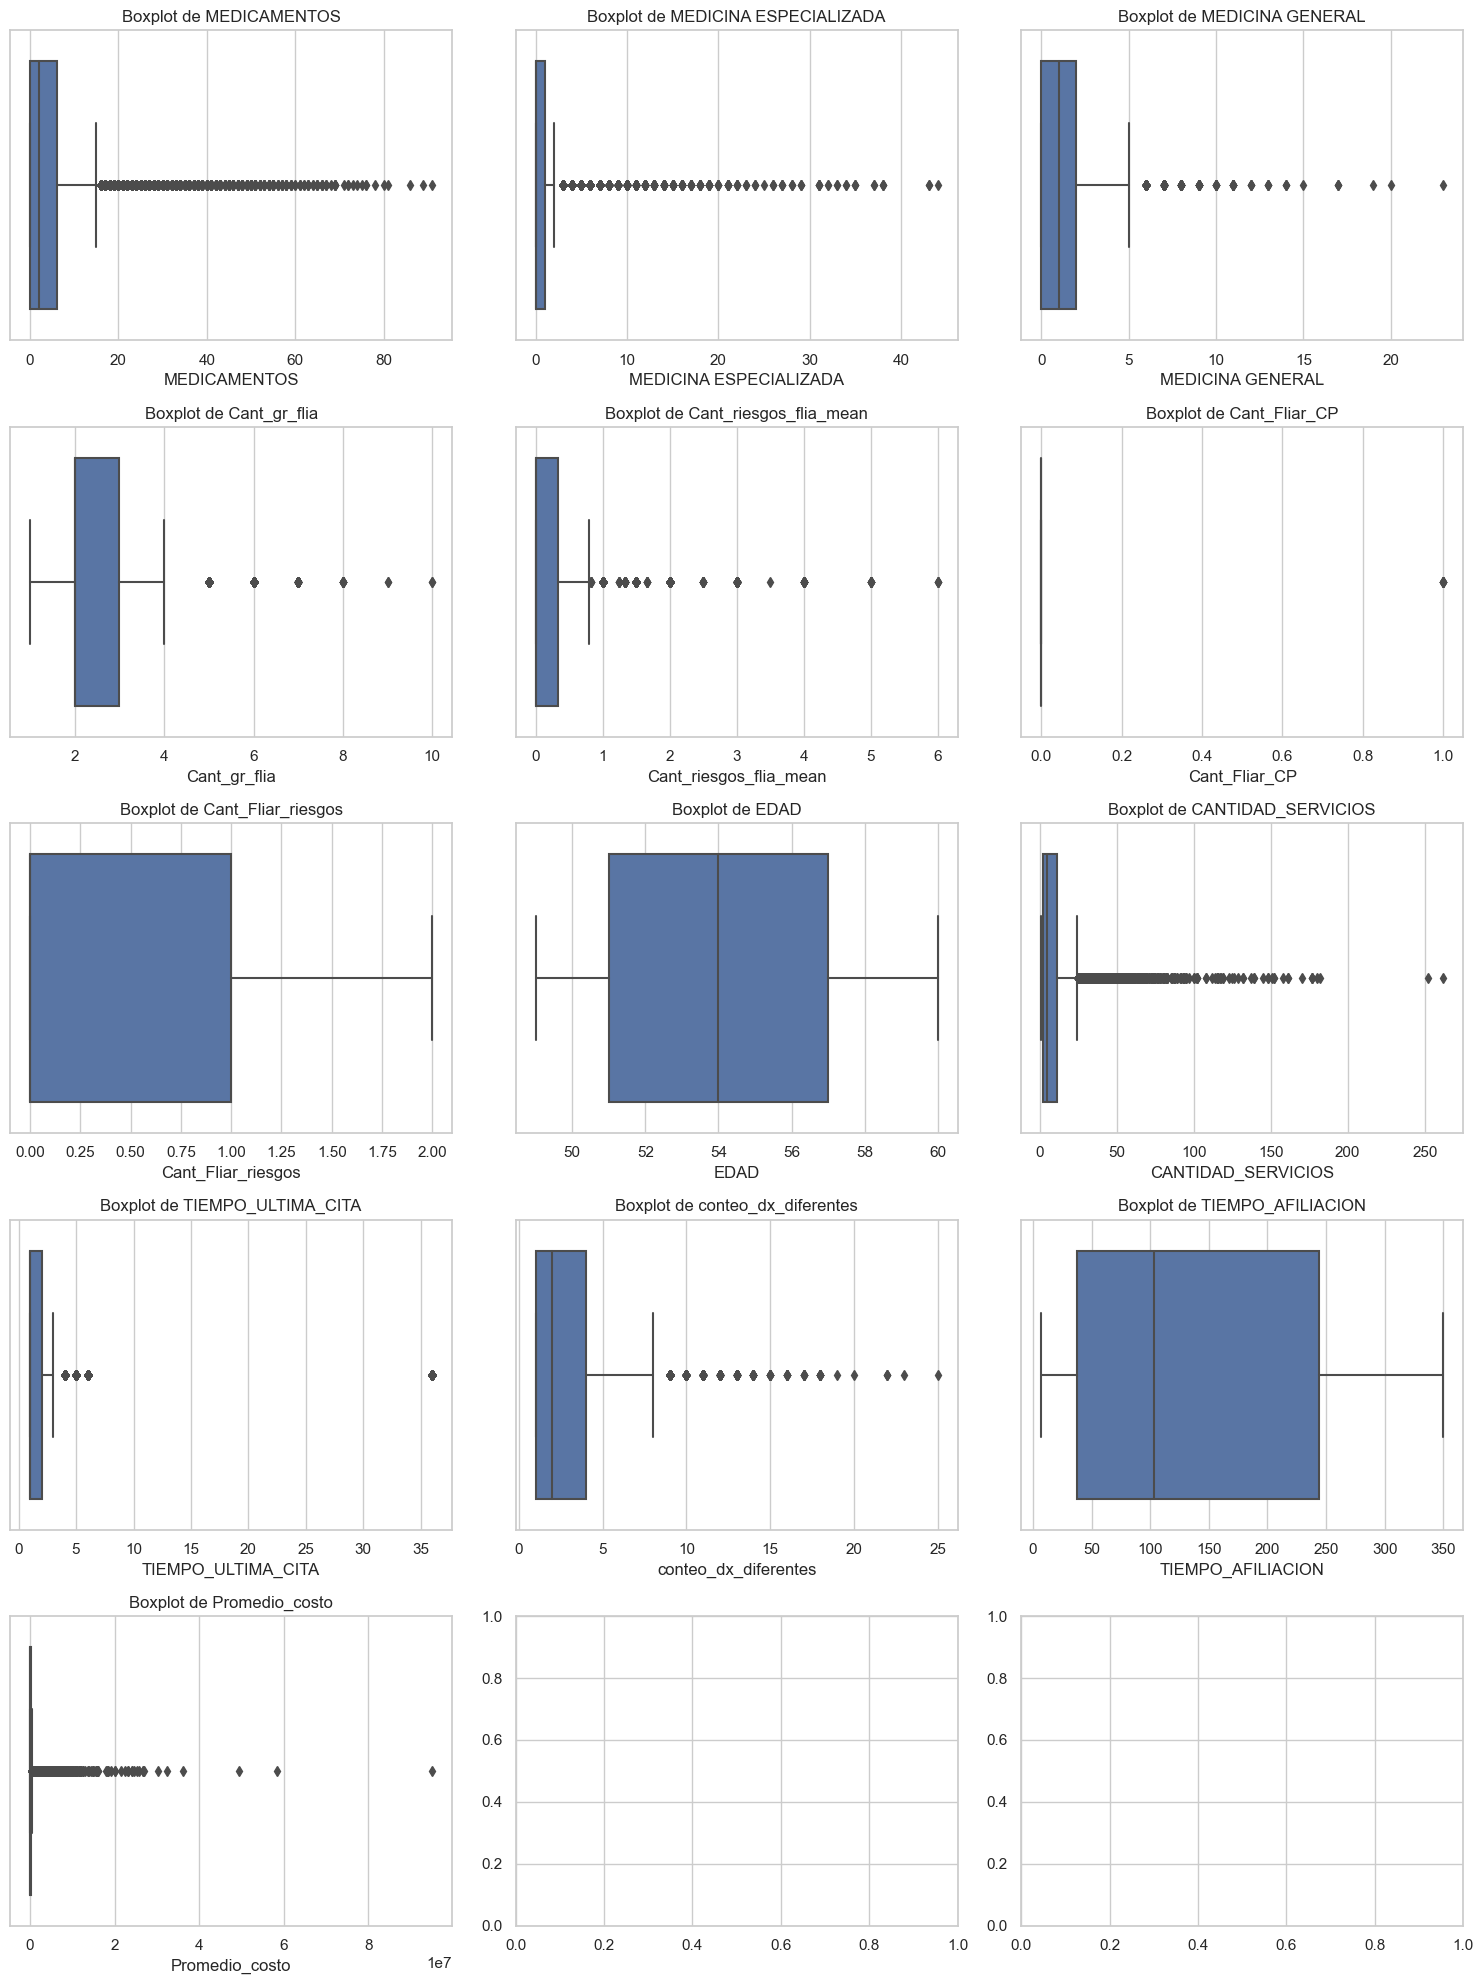

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configura el estilo de los gráficos
sns.set(style='whitegrid')

# Selecciona las columnas numéricas
num_cols = df_train_3.select_dtypes(include=['float64', 'int64']).columns

# Determina el número total de columnas y filas necesarias
num_cols_total = len(num_cols)
num_rows = (num_cols_total // 3) + (num_cols_total % 3 > 0)

# Crea la figura y los ejes
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 4))

# Aplana la matriz de ejes para facilitar la iteración
axes = axes.flatten()

# Crea un boxplot para cada variable numérica
for i, col in enumerate(num_cols):
    sns.boxplot(x=df_train_3[col], ax=axes[i])
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_xlabel(col)

# Ajusta el espacio entre los gráficos
plt.tight_layout()
plt.show()


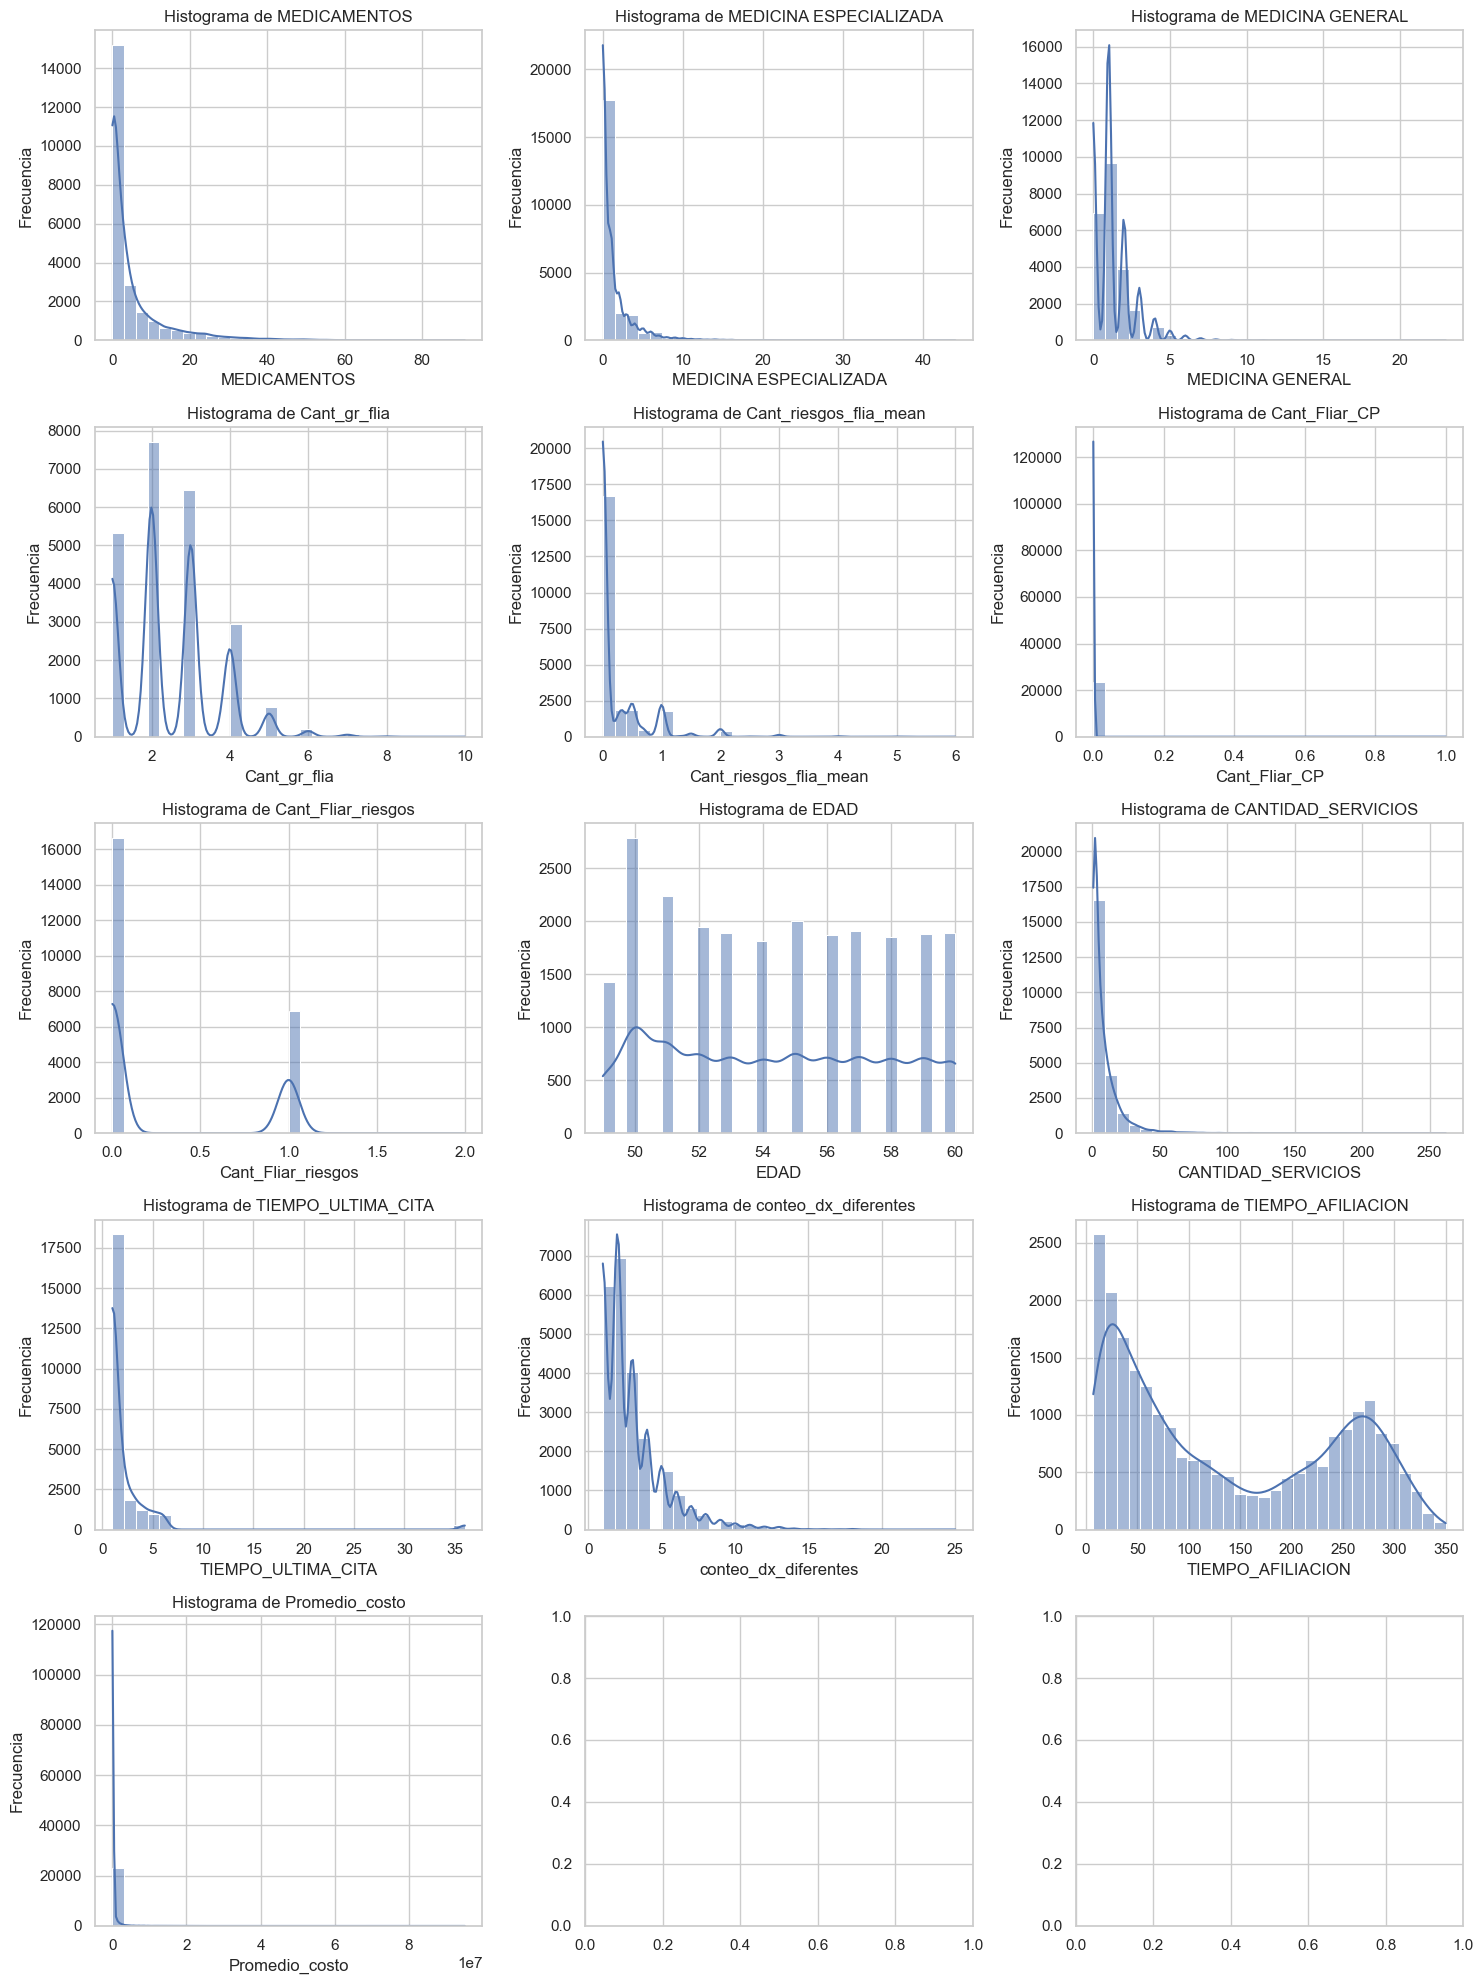

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configura el estilo de los gráficos
sns.set(style='whitegrid')

# Selecciona las columnas numéricas
num_cols = df_train_3.select_dtypes(include=['float64', 'int64']).columns

# Determina el número total de columnas y filas necesarias
num_cols_total = len(num_cols)
num_rows = (num_cols_total // 3) + (num_cols_total % 3 > 0)

# Crea la figura y los ejes
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 4))

# Aplana la matriz de ejes para facilitar la iteración
axes = axes.flatten()

# Crea un histograma para cada variable numérica
for i, col in enumerate(num_cols):
    sns.histplot(df_train_3[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Histograma de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

# Ajusta el espacio entre los gráficos
plt.tight_layout()
plt.show()


In [20]:
# Estadísticas descriptivas
stats = df_train_3[num_cols].describe()
print(stats)

       MEDICAMENTOS  MEDICINA ESPECIALIZADA  MEDICINA GENERAL  Cant_gr_flia  \
count  23494.000000            23494.000000      23494.000000  23494.000000   
mean       5.201669                1.285094          1.244190      2.451392   
std        8.830948                2.669005          1.337775      1.153336   
min        0.000000                0.000000          0.000000      1.000000   
25%        0.000000                0.000000          0.000000      2.000000   
50%        2.000000                0.000000          1.000000      2.000000   
75%        6.000000                1.000000          2.000000      3.000000   
max       91.000000               44.000000         23.000000     10.000000   

       Cant_riesgos_flia_mean  Cant_Fliar_CP  Cant_Fliar_riesgos  \
count            23494.000000   23494.000000        23494.000000   
mean                 0.227974       0.000341            0.291947   
std                  0.485658       0.018450            0.454761   
min             

In [21]:
def detect_outliers_iqr(data):
    outlier_indices = []
    for col in num_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        # Detectar outliers
        outliers = data[(data[col] < Q1 - outlier_step) | (data[col] > Q3 + outlier_step)]
        outlier_indices.extend(outliers.index.tolist())
    return set(outlier_indices)

outlier_indices = detect_outliers_iqr(df_train_3)
print(f'Número de outliers detectados: {len(outlier_indices)}')


Número de outliers detectados: 10814


In [24]:
from scipy.stats import mstats

# Aplica winsorización a cada variable numérica
for col in num_cols:
    df_train_3[col] = mstats.winsorize(df_train_3[col], limits=[0.05, 0.05])  # Winsoriza el 1% inferior y superior


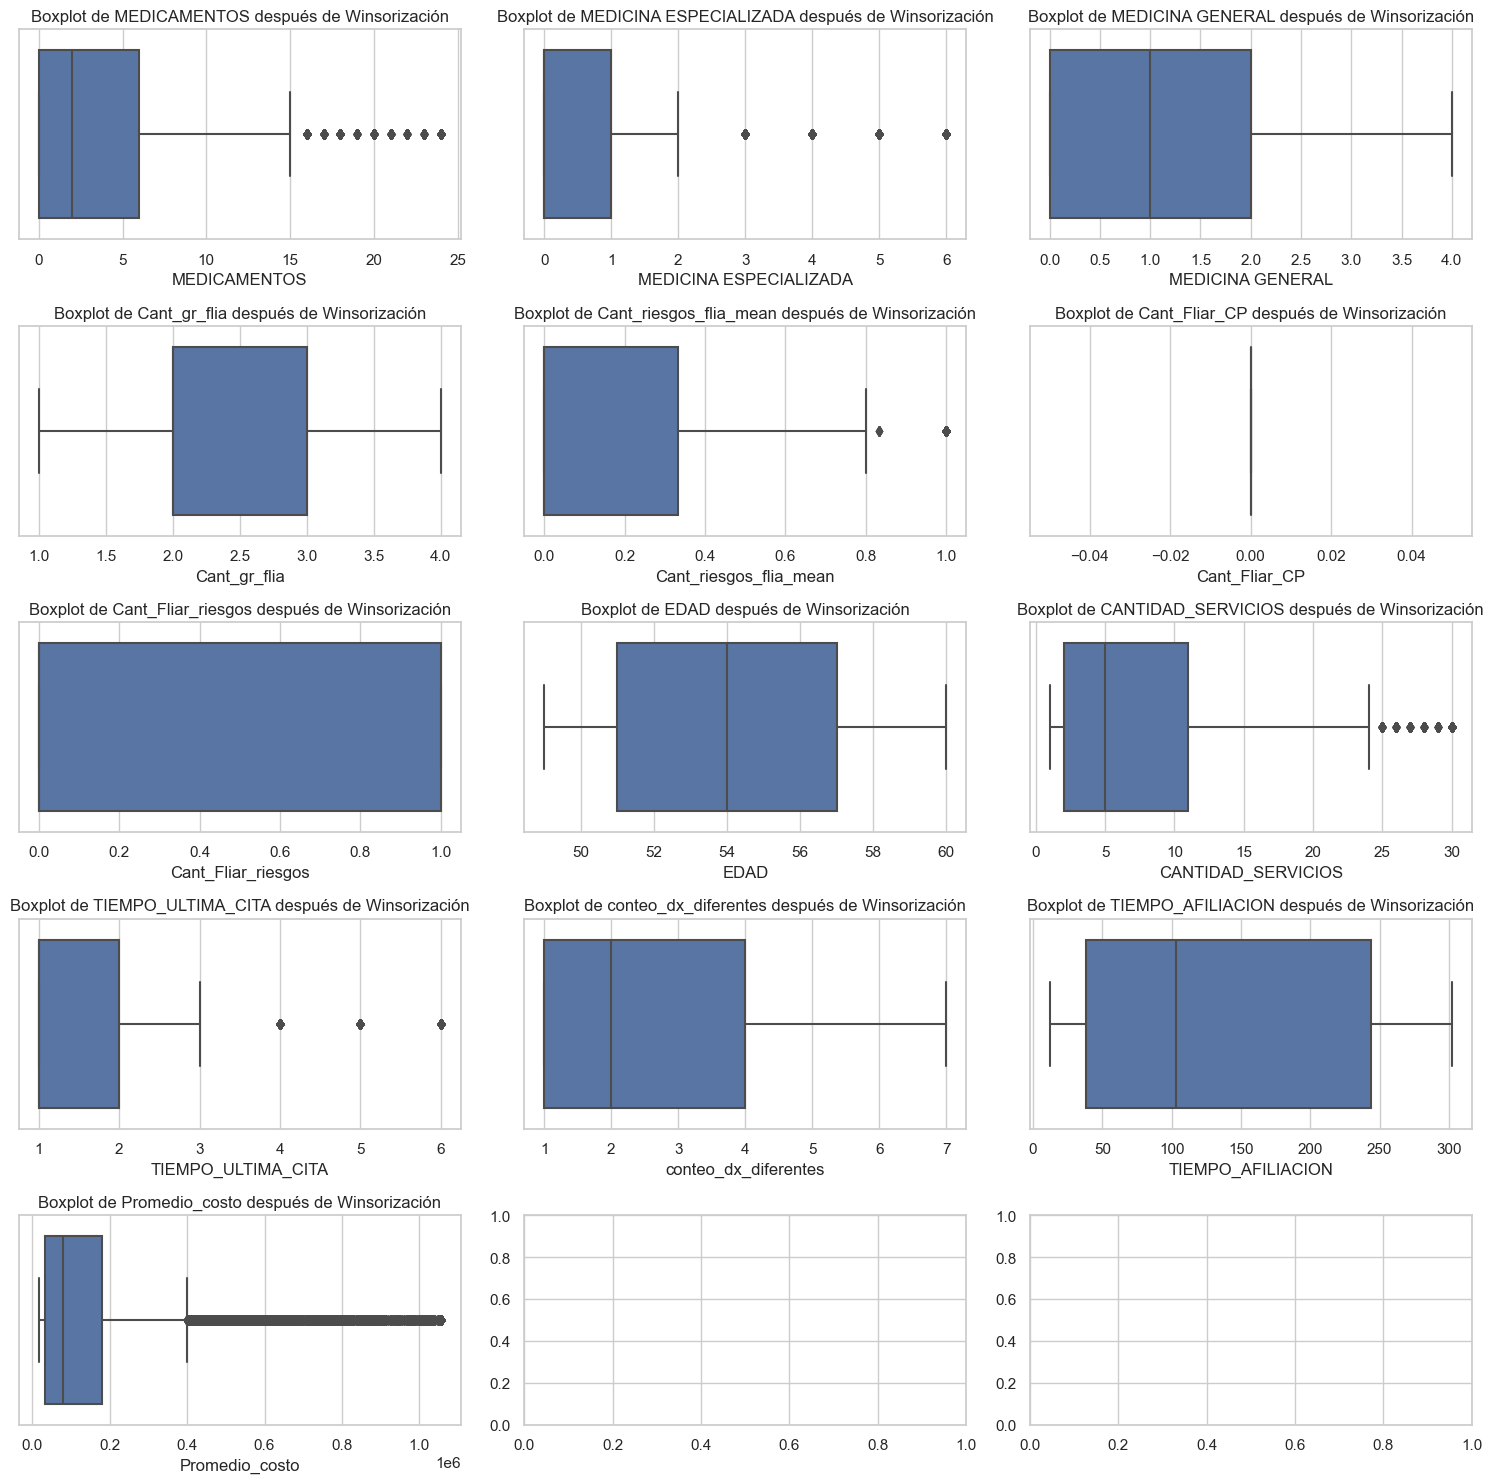

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configura el estilo de los gráficos
sns.set(style='whitegrid')

# Selecciona las columnas numéricas
num_cols = df_train_3.select_dtypes(include=['float64', 'int64']).columns

# Crea la figura y los ejes para los subgráficos
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))  # 5 filas y 3 columnas
axes = axes.flatten()  # Aplana la matriz de ejes para facilitar la indexación

# Crea un boxplot para cada variable numérica
for i, col in enumerate(num_cols):
    sns.boxplot(x=df_train_3[col], ax=axes[i])
    axes[i].set_title(f'Boxplot de {col} después de Winsorización')
    axes[i].set_xlabel(col)

# Ajustar el layout para que no se superpongan
plt.tight_layout()
plt.show()


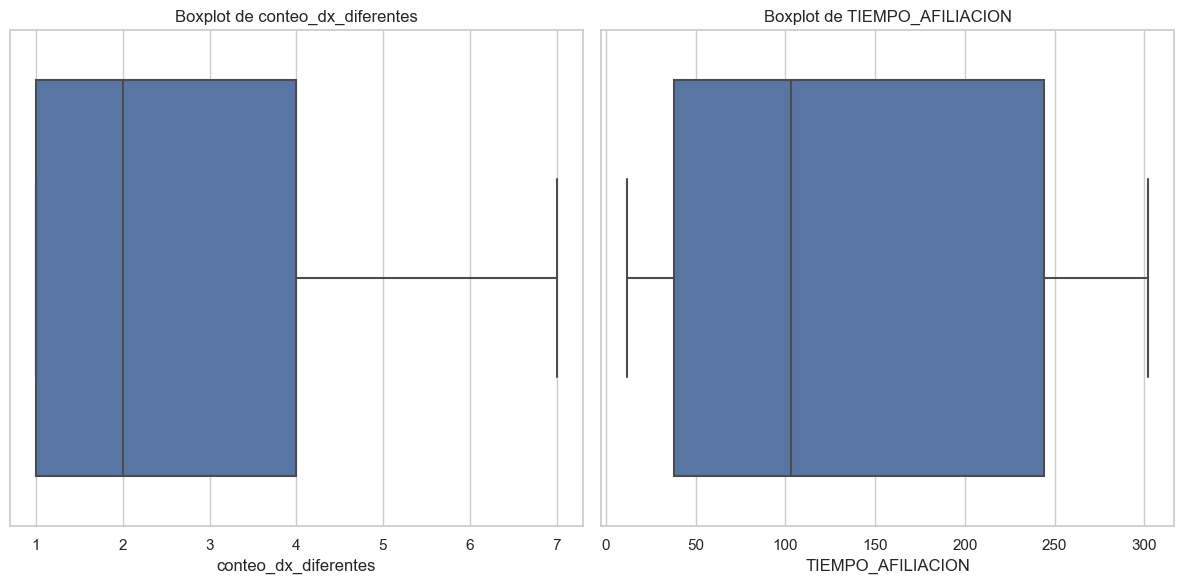

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configura el estilo de los gráficos
sns.set(style='whitegrid')

# Crea una figura y ejes para los boxplots
plt.figure(figsize=(12, 6))

# Boxplot para conteo_dx_diferentes
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer subplot
sns.boxplot(x=df_train_3['conteo_dx_diferentes'])
plt.title('Boxplot de conteo_dx_diferentes')
plt.xlabel('conteo_dx_diferentes')

# Boxplot para TIEMPO_AFILIACION
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo subplot
sns.boxplot(x=df_train_3['TIEMPO_AFILIACION'])
plt.title('Boxplot de TIEMPO_AFILIACION')
plt.xlabel('TIEMPO_AFILIACION')

# Muestra los plots
plt.tight_layout()
plt.show()


Posterior al ejercicio de Winsorización, la variable Promedio_costo continua con presencia de muchos datos atípicos.

In [29]:
# Eliminar la columna 'Promedio_costo' del DataFrame
df_train_3 = df_train_3.drop(columns=['Promedio_costo'])

# Verificar que la columna se ha eliminado
print(df_train_3.info())


<class 'pandas.core.frame.DataFrame'>
Index: 23494 entries, 16484 to 9409
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MEDICAMENTOS                   23494 non-null  float64
 1   MEDICINA ESPECIALIZADA         23494 non-null  float64
 2   MEDICINA GENERAL               23494 non-null  float64
 3   Cant_gr_flia                   23494 non-null  int64  
 4   Cant_riesgos_flia_mean         23494 non-null  float64
 5   Cant_Fliar_CP                  23494 non-null  float64
 6   Cant_Fliar_riesgos             23494 non-null  float64
 7   ESTADO_CIVI                    23494 non-null  object 
 8   PROGRAMA                       23494 non-null  object 
 9   estrato                        23494 non-null  object 
 10  AGRUPACION_SISTOLICA           23494 non-null  object 
 11  AGRUPACION_DIASTOLICA          23494 non-null  object 
 12  parentesco                     23494 non-null  o

**Análisis de Feature Importance**

=====

In [44]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Dividir el DataFrame en características (X) y etiqueta (y)
X = df_train_3.drop(columns=['Target'])
y = df_train_3['Target']

# Identificar columnas numéricas y categóricas
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Crear un pipeline para el procesamiento de datos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Crear el modelo Random Forest
model = RandomForestClassifier(random_state=42)

# Crear el pipeline completo
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', model)])

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustar el pipeline al conjunto de entrenamiento
pipeline.fit(X_train, y_train)

# Obtener la importancia de las características
importances = pipeline.named_steps['classifier'].feature_importances_

# Obtener nombres de las características
ohe_features = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)
feature_names = np.concatenate([numerical_cols, ohe_features])

# Crear un DataFrame de importancia
importance_df = pd.DataFrame(importances, index=feature_names, columns=['Importancia']).sort_values(by='Importancia', ascending=False)

# Mostrar el DataFrame de importancia de características
print(importance_df)


                                Importancia
TIEMPO_AFILIACION                  0.140280
EDAD                               0.109050
CANTIDAD_SERVICIOS                 0.083538
MEDICAMENTOS                       0.072099
conteo_dx_diferentes               0.053435
...                                     ...
ESTADO_CIVI_VI                     0.000317
AGRUPACION_SISTOLICA_Hipotenso     0.000215
parentesco_Hijo                    0.000032
estrato_None                       0.000006
Cant_Fliar_CP                      0.000000

[83 rows x 1 columns]


In [47]:
import plotly.express as px

# Crear un DataFrame para la importancia de las características
importance_df = importance_df.reset_index().rename(columns={'index': 'Características'})

# Crear el gráfico interactivo
fig = px.bar(importance_df, 
             x='Importancia', 
             y='Características', 
             orientation='h', 
             title='Importancia de las Características',
             labels={'Importancia': 'Importancia', 'Características': 'Características'},
             text='Importancia',  # Mostrar los valores sobre las barras
             color='Importancia',  # Color según la importancia
             color_continuous_scale='Blues')

# Actualizar diseño del gráfico
fig.update_traces(texttemplate='%{text:.4f}', textposition='outside')
fig.update_layout(yaxis=dict(title='Características'), 
                  xaxis=dict(title='Importancia'), 
                  title_x=0.5,  # Centrar el título
                  plot_bgcolor='rgba(0,0,0,0)',  # Fondo transparente
                  height=800)  # Ajustar la altura

# Mostrar el gráfico
fig.show()


**Pruebas de Modelos**

========================================================================

In [5]:
#Identificamos el grupo de variables numéricas y categóricas, que serán utilizadas para realizar un análisis descriptivo inicial. 

df_numerico = df_train.select_dtypes(include=['int64', 'float64'])

df_categorico = df_train.select_dtypes(include=['object', 'category'])




## **2.1. Análisis Exploratorio de Variables Numéricas**

In [ ]:
df_numerico.info()

In [7]:
# Función para obtener la tabla completa de estadísticas descriptivas
def tabla_descriptivas_completa(columnas):
    tabla_descriptivas = pd.DataFrame(columnas.describe())
    tabla_descriptivas.loc['coef. variation'] = columnas.std() / columnas.mean()
    tabla_descriptivas.loc['skew'] = skew(columnas) 
    tabla_descriptivas.loc['kurtosis'] = kurtosis(columnas)
    return tabla_descriptivas

**Estadísticas Descriptivas**

In [ ]:
columnas_numericas = df_numerico.select_dtypes(include=['float64', 'int64']).columns


resultados = {}


for columna in columnas_numericas:
    resultados[columna] = tabla_descriptivas_completa(df_numerico[columna])


for key, value in resultados.items():
    print(f"\nEstadísticas descriptivas para {key}:\n")
    display(value)  # Mostrar la tabla con formato
    print("\n" + "="*50 + "\n")

**Interpretación:**

PENDIENTE

**Gráficos de Distribución de Variables Numéricas**

In [ ]:
columnas_numericas = df_numerico.select_dtypes(include=['float64', 'int64']).columns

fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(18, 25))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

colores = sns.color_palette("husl", len(columnas_numericas))

for i, (columna, ax) in enumerate(zip(columnas_numericas, axes.flatten())):
    sns.histplot(x=df_numerico[columna], kde=True, color=colores[i], ax=ax)
    ax.set_title(f'Distribución de {columna}', fontsize=10)
    ax.set_xlabel(f'{columna}', fontsize=8)
    ax.set_ylabel('Frecuencia', fontsize=8)

for j in range(i + 1, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


**Gráficas de Boxplot - Variables Numéricas**

In [ ]:
columnas_numericas = df_numerico.select_dtypes(include=['float64', 'int64']).columns

fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(18, 24))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

colores = sns.color_palette("husl", len(columnas_numericas))

for i, (columna, ax) in enumerate(zip(columnas_numericas, axes.flatten())):
    sns.boxplot(x=df_numerico[columna].dropna(), color=colores[i], showmeans=True, ax=ax)
    ax.set_title(f'Boxplot de {columna}', fontsize=10)
    ax.set_xlabel(f'{columna}', fontsize=8)

for j in range(i + 1, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


**Interpretación**

Teniendo en cuenta los resultados anteriores, se encontró una presencia significativa de valores atípicos en una gran cantidad de variables del dataset. La falta de tratamiento de estos datos extremos podría impactar negativamente la capacidad predictiva de los modelos que se desarrollarán posteriormente. Por tanto, una de las estrategias que se implementará para abordar este problema es la **winsorización**, que permitirá mitigar el efecto de los outliers y mejorar la estabilidad y precisión de las predicciones.




**Análisis de Correlación - Variables Numéricas**

In [ ]:
plt.figure(figsize=(14, 12))
sns.heatmap(df_numerico.corr(), annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})


plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)  

plt.title('Mapa de Calor de Correlación', fontsize=16)
plt.tight_layout() 
plt.show()



**Análisis de Datos Nulos - Variables Numéricas**

In [ ]:
conteo_nulos = df_numerico.isnull().sum()

conteo_nulos = conteo_nulos[conteo_nulos > 0].sort_values(ascending=False)

plt.figure(figsize=(10, 6))

sns.barplot(x=conteo_nulos.values, y=conteo_nulos.index, palette='viridis')

for index, value in enumerate(conteo_nulos.values):
    plt.text(value, index, str(value), color='black', va='center')

sns.despine()

plt.title('Número de datos nulos - Variables Numéricas', fontsize=14)
plt.xlabel('Número de Nulos', fontsize=12)
plt.ylabel('Variables', fontsize=12)

plt.show()


**Interpretación**

En la base de datos se identificaron un total de 24 variables numéricas. Según el gráfico anterior, 5 de ellas cuentan con la presencia de valores nulos en los datos, estas son: **min_Tiempo_CP_Fliar** (Tiempo desde la marca del CA de Prostata Familiar), **psa_max_gr_flia** (Resultado PSA Maximo del grupo familiar), **psa_min_gr_flia** (Resultado PSA Minimo del grupo familiar), **perdida_de_peso** (Peso perdido/ganado en el ultimo año) y **riesgos** (cantidad de riesgos del usuario).

Teniendo en cuenta el porcentaje de valores nulos para cada una de las variables en relación con el tamaño del dataset (23.494), este resultado parece sugerir la eliminación de alguna de estas variables: 

- **min_Tiempo_CP_Fliar** - 99% de datos nulos
- **psa_max_gr_flia** - 99,3%
- **psa_min_gr_flia** - 99,3%
- **perdida_de_peso** - 75,4%
- **riesgos** - 69,3%

No obstante, más adelante a lo largo de este análisis se harán propuestas de otras técnicas para entender la validez de estas variables sobre el modelo. Esto debido a que variables relacionadas con los resultados máximos o mínimos de PSA pueden generar algún tipo de importancia dentro de los análisis. 


**Otros Análisis**

Identificación del promedio de medicamentos usados por grupos de edad.

In [ ]:
bins = [49, 52, 55, 58, 61] 
labels = ['49-51', '52-54', '55-57', '58-60']

df_numerico['Rango_Edad'] = pd.cut(df_numerico['EDAD'], bins=bins, labels=labels, right=False)

medicamentos_por_edad = df_numerico.groupby('Rango_Edad')['MEDICAMENTOS'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=medicamentos_por_edad, x='Rango_Edad', y='MEDICAMENTOS', palette='magma')  # Cambiar la paleta de colores

plt.title('Número de medicamentos promedio usados según rangos de edad', fontsize=16)
plt.xlabel('Rango de Edad', fontsize=14)
plt.ylabel('Promedio de Medicamentos', fontsize=14)

# Mostrar el gráfico
plt.show()


**Interpretación**

En el gráfico anterior, se propone un análisis en el cual se evidencia el promedio de medicamentos que utilizaron las personas según el rango de edad al que pertenecen. Para este conjunto de datos, se encontró que las personas que se encuentran en el grupo etario más avanzado son aquellos que utilizaron la mayor cantidad de medicamentos (en promedio), este valor correspondió a aproximadamente 6 medicamentos para las personas entre 58 a 60 años. Seguido a este grupo, aparecen las personas entre 55 y 57 años que usaron aproximadamente 5 medicamentos en promedio en el último semestre. 

Por supuesto, esto da un indicio que son las personas más longevas las que requieren una mayor cantidad de medicamentos debido a que es posible que cuenten con mayores problemas de salud. 

In [ ]:
bins = [49, 52, 55, 58, 61]  # Rango de 49 a 60
labels = ['49-51', '52-54', '55-57', '58-60']


df_numerico['Rango_Edad'] = pd.cut(df_numerico['EDAD'], bins=bins, labels=labels, right=False)


medicina_especializada_por_edad = df_numerico.groupby('Rango_Edad')['MEDICINA ESPECIALIZADA'].mean().reset_index()
medicina_general_por_edad = df_numerico.groupby('Rango_Edad')['MEDICINA GENERAL'].mean().reset_index()


combined_data = pd.merge(medicina_especializada_por_edad, medicina_general_por_edad, on='Rango_Edad', suffixes=('_Especializada', '_General'))


plt.figure(figsize=(12, 5))
bar_width = 0.35  
x = range(len(combined_data['Rango_Edad']))


plt.bar(x, combined_data['MEDICINA ESPECIALIZADA'], width=bar_width, label='Promedio Medicina Especializada', color='royalblue')
plt.bar([p + bar_width for p in x], combined_data['MEDICINA GENERAL'], width=bar_width, label='Promedio Medicina General', color='lightcoral')


plt.title('Promedio de Medicina Especializada y General por Rango de Edad', fontsize=16)
plt.xlabel('Rango de Edad', fontsize=14)
plt.ylabel('Promedio de Medicina', fontsize=14)
plt.xticks([p + bar_width / 2 for p in x], combined_data['Rango_Edad'])  
plt.legend()


plt.tight_layout()
plt.show()


**Interpretación**

Previamente en las estadísticas descriptivas se observó que la cantidad de servicios de medicina (tanto especializada como general) era relativamente baja, lo cual se confirma en la gráfica anterior. Sin embargo, a pesar del bajo uso de servicios en los últimos semestres, el grupo etario de 58 a 60 años destaca por haber utilizado el mayor promedio de servicios de medicina especializada.

==============================================

## **2.2. Análisis Exploratorio de Variables Categóricas**

In [ ]:
df_categorico.info()

In [16]:
# Función para obtener tablas de frecuencias para las variables categóricas

def tabla_freq(columna):
    x=pd.crosstab(index=columna,columns="count").reset_index()
    x=x.rename(columns={'count':'Frec. Abs.'})
    y=pd.crosstab(index=columna,columns="count", normalize='columns').reset_index()
    y=y.rename(columns={'count':'Frec. Rel.'})
    tabla=x.merge(y,how='left')
    tabla.rename_axis(None, axis=1)
    return tabla

**Tablas de Frecuencia**

In [ ]:
columnas_categoricas = df_categorico.select_dtypes(include=['object']).columns

resultados_categoricos = {}

for columna in columnas_categoricas:
    resultados_categoricos[columna] = tabla_freq(df_categorico[columna])

for key, value in resultados_categoricos.items():
    print(f"\nTabla de Frecuencia para {key}:\n")
    display(value)  # Mostrar la tabla con formato
    print("\n" + "="*50 + "\n")

**Interpretación:**

PENDIENTE

**Distribución % de las categorías - Variables Categóricas**

In [ ]:
columnas_categoricas = df_categorico.select_dtypes(include=['object']).columns

# Presentación de los gráficos en términos de filas y columnas
n_filas = 11
n_columnas = 2
n_graficos = len(columnas_categoricas)

fig, axes = plt.subplots(n_filas, n_columnas, figsize=(14, 40))
axes = axes.flatten() 

colors = sns.color_palette("husl", n_graficos)

for i, columna in enumerate(columnas_categoricas):
    descriptivas = tabla_freq(df_categorico[columna])
    
    # Construcción del gráfico de barras
    frec_aprob = sns.barplot(
        ax=axes[i],
        x=descriptivas[columna],
        y=descriptivas["Frec. Rel."] * 100,
        color=colors[i]
    )
    
    # Añadir etiquetas de porcentaje
    frec_aprob.bar_label(frec_aprob.containers[0], label_type='edge', fmt='%.2f%%', padding=3)
    
    # Formato de porcentaje en el eje y
    frec_aprob.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
    frec_aprob.set(ylim=(0, 100))
    
    # Configurar el título
    axes[i].set_title(f'Distribución de {columna}', fontsize=12)
    
    axes[i].set_xticklabels(descriptivas[columna], rotation=45, ha='right')

# Ajustar el layout para evitar solapamientos
plt.tight_layout()

for j in range(n_graficos, n_filas * n_columnas):
    axes[j].axis('off')

plt.show()

Interpretación: 

- Inicialmente, se encontró que los pacientes no están accediendo a la atención necesaria, pues hay un bajo uso de Medicina Especializada y General, teniendo en cuenta la media de la cantidad de servicios de ambos tipos de medicina en los últimos semestres (5,2 y 1,28 respectivamente).

- Teniendo en cuenta el promedio de la **cantidad de personas por grupo familiar**, se observa que la mayoría de las familias son relativamente pequeñas. 

- En relación con la **edad** de los pacientes se encontró una media de 54,37. Adicionalmente, se destaca que las edades oscilan en un rango de 49 a 60 años. 

- En el caso de la variable **riesgos**, se destaca que cuenta con una cantidad de 7.211 observaciones, es decir, que no se registró para todos los individuos que hay en el conjunto de datos. Para dicha variable la media es de 1,49, lo que sugiere que la mayoría de pacientes o usuarios parecen tener un bajo número de riesgos, un resultado positivo desde el punto de vista médico. 

- Ahora bien, realizando una primera aproximación de las variables que sugieren problemas de datos faltantes, se resaltan las siguientes: **min_Tiempo_CP_Fliar** (solo cuenta con 8 observaciones de 23.494), **psa_max_gr_flia** y **psa_min_gr_flia** (solo tienen 164 observaciones) y **RIESGOS** (tiene 7.211 observaciones)

**Análisis de Datos Nulos - Variables Categóricas**

In [ ]:
conteo_nulos_categorico = df_categorico.isnull().sum()
conteo_nulos_categorico = conteo_nulos_categorico[conteo_nulos_categorico > 0].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=conteo_nulos_categorico.values, y=conteo_nulos_categorico.index, palette='viridis')

for index, value in enumerate(conteo_nulos_categorico.values):
    plt.text(value, index, str(value), color='black', va='center')

sns.despine()
plt.title('Número de datos nulos - Variables Categóricas', fontsize=14)
plt.xlabel('Número de Nulos', fontsize=12)
plt.ylabel('Variables', fontsize=12)

plt.show()

**Interpretación**

En la base de datos se identificaron un total de XX variables categóricas. A diferencia del análisis para variables numéricas, es importante resaltar que para este caso, las variables que presentan datos nulos no están tan graves en términos del % de los datos ausentes, en comparación con el estado de las variables con datos nulos de las numéricas. 

En este caso se identificaron 4 variables categóricas con presencia de nulos: 

- **IMC** - 44,1% de datos nulos 
- **CANCER_MAMA_FAMILIAR** - 28,9%
- **AGRUPACION_SISTOLICA** - 14,1%
- **AGRUPACION_DIASTOLICA** - 14,1%

En este caso, el panorama indica que es posible tratar estas variables con técnicas de imputación que se trabajarán más adelante. También, se resalta que se utilizarán técnicas para identificar si realmente estas variables son importantes para el modelo. 

**PENDIENTES Felipe M**

- Análisis o cruces entre categóricas y numéricas. 
- Análisis de feature selection

# **3. Entendimiento y Preparación de los Datos**

## **3.1. Análisis del Baseline**

Teniendo en cuenta las recomendaciones del negocio, se utilizará la moda como enfoque para establecer un modelo baseline en este análisis. En este caso, el modelo predecirá la clase '0', ya que es la que presenta la mayor frecuencia en el conjunto de datos, representado por el 70% de las instancias, mientras que la clase '1' solo representa el 30%.

Este enfoque resulta en una precisión del 70%, lo que significa que la evaluación de los modelos posteriores deben superar este umbral para demostrar que se están generando predicciones más útiles. 

In [ ]:
print("Distribución de Target en df_train (%):")
print(y_train.value_counts(normalize=True))

# También puedes imprimir los valores absolutos para tener ambas referencias
print("\nDistribución de Target en df_train (absoluto):")
print(y_train.value_counts())

## **3.2. Imputación de Valores & Feature Engineering**

Teniendo en cuenta el entendimiento previo de los datos, en esta sección se desarrollarán las técnicas de imputación definidas para las variables que cuenten con ausencia de información. Adicionalmente, se desarrollarán todos los pasos asociados al tratamiento de variables categóricas:

- Aplicación de la estrategia de one hot encoding
- Análisis de Componentes Principales 
- Técnica de Feature Importance para la selección de variables. 

# **5. Calibración y selección de modelo**

En esta sección, se desarrollarán los modelos  para estimar la probabilidad de resultados anormales de PSA. Se implementarán diferentes enfoques, incluyendo Support Vector Classifier (SVC) y Redes Neuronales, utilizando custom transformers y pipelines para optimizar el flujo de trabajo y garantizar una integración eficiente de las etapas de preprocesamiento y modelado. Adicionalmente, se hará uso de la técnica de optimización bayesiana para encontrar los mejores hiperparametros de los modelos mencionados.

## **5.1. SVC con diferentes kernels**

## **5.2. Redes Neuronales**

## **5.5. Escogencia de Flujo Final**

====================================================